In [1]:
import numpy as np
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Modeling

## FC Block

In [2]:
class FC_Block(tf.keras.layers.Layer) : 
    def __init__(self, units = 32) : 
        super(FC_Block, self).__init__()
        self.units = units
        self.linear = tf.keras.layers.Dense(units, kernel_initializer = 'he_normal')
        self.batch = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.dropout = tf.keras.layers.Dropout(0.2)

    def call(self, inputs, training = False) : 
        x = self.linear(inputs)
        x = self.batch(x, training = training) 
        x = self.relu(x)
        x = self.dropout(x)

        return x

## Auto Encoder

In [3]:
class AutoEncoder(tf.keras.Model) : 

    def __init__(self , denoise = False) : 
        super(AutoEncoder,self).__init__()
        self.denoise = denoise
        self.linear1 = FC_Block(512)
        self.linear2 = FC_Block(256)
        self.linear3 = FC_Block(64)
        self.linear4 = FC_Block(32)
        self.linear5 = FC_Block(64)
        self.linear6 = FC_Block(256)
        self.linear7 = FC_Block(512)
        self.decoder = tf.keras.layers.Dense(28*28)

    def call(self, input) : 
        if self.denoise : 
            input += np.random.normal(0, 0.05, 28*28)
        x = self.linear1(input)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        x = self.linear5(x)
        x = self.linear6(x)
        x = self.linear7(x)
        decoded = self.decoder(x)

        return decoded

In [4]:
batch_size = 480*4
AE = AutoEncoder(denoise = False)
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.MeanSquaredError()
AE.compile(optimizer, loss_fn)

DAE = AutoEncoder(denoise = True)
DAE.compile(optimizer, loss_fn)


## MLP_Classifier

In [5]:
class MLP_Classifier(tf.keras.Model) : 
    def __init__(self) : 
        super(MLP_Classifier, self).__init__()
        self.mlp1 = FC_Block(256)
        self.mlp2 = FC_Block(64)
        self.mlp3 = FC_Block(16)
        self.linear = tf.keras.layers.Dense(10)
    
    def call(self, inputs) : 
        x = self.mlp1(inputs)
        x = self.mlp2(x)
        x = self.mlp3(x)
        x = self.linear(x)

        return tf.nn.softmax(x)

# Load Data

In [6]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, y_train, X_test, y_test = X_train.astype(float), y_train.astype(float), X_test.astype(float), y_test.astype(float)
X_train = X_train.reshape(-1,28 * 28) / 255
X_test = X_test.reshape(-1,28 * 28) / 255

print("TRAIN DATA : ", X_train.shape, y_train.shape)
print("TEST  DATA : ", X_test.shape, y_test.shape)

TRAIN DATA :  (60000, 784) (60000,)
TEST  DATA :  (10000, 784) (10000,)


In [7]:
from sklearn.model_selection import train_test_split
train_idx, valid_idx = train_test_split(np.arange(X_train.shape[0]), test_size = 0.2, shuffle = True, random_state = 100, stratify = y_train)
X_train_images = X_train[train_idx]
X_train_labels = y_train[train_idx]
X_valid_images = X_train[valid_idx]
X_valid_labels = y_train[valid_idx]

print("TRAIN DATA : ", X_train_images.shape, X_train_labels.shape)
print("VALID DATA : ", X_valid_images.shape, X_valid_labels.shape)

TRAIN DATA :  (48000, 784) (48000,)
VALID DATA :  (12000, 784) (12000,)


# Training

In [8]:
def return_callbacks(save_path, patience) : 
    early = tf.keras.callbacks.EarlyStopping('val_loss', patience = patience, mode = 'min')
    mckt = tf.keras.callbacks.ModelCheckpoint(save_path, monitor = 'val_loss', save_weights_only=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = patience // 3, min_lr = 1e-5)

    return [early, mckt, reduce_lr]

In [9]:
def draw_history(history, need_acc = False) : 
    import matplotlib
    import matplotlib.pyplot as plt
    fig, loss_ax = plt.subplots()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    if need_acc : 
        acc_ax = loss_ax.twinx()
        acc_ax.plot(history.history['accuracy'], 'b', label='train accuracy')
        acc_ax.plot(history.history['val_accuracy'], 'g', label='val accuracy')
        acc_ax.set_ylabel('accuracy')
        acc_ax.legend(loc='upper left')

    plt.show()

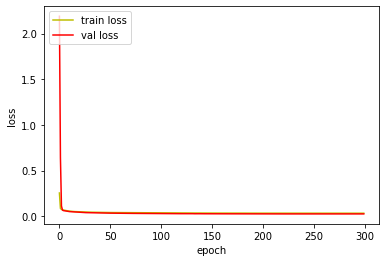

In [10]:
ae_ckpt = 'AE_checkpoint.h5'
patience = 50
history = AE.fit(X_train_images, X_train_images,
        validation_data = (X_valid_images, X_valid_images),
        batch_size = batch_size,
        epochs = 300,
        verbose = 0, 
        callbacks= return_callbacks(ae_ckpt, patience)
        )
AE.load_weights(ae_ckpt)
draw_history(history)

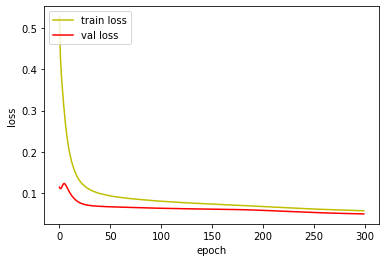

In [11]:
dae_ckpt = 'DAE_checkpoint.h5'
patience = 50
history = DAE.fit(X_train_images, X_train_images,
        validation_data = (X_valid_images, X_valid_images),
        batch_size = batch_size,
        epochs = 300,
        verbose = 0, 
        callbacks= return_callbacks(dae_ckpt, patience)
        )
DAE.load_weights(dae_ckpt)
draw_history(history)

## Reconstruct Images

In [12]:
def draw_new_images(model, denoise = False) : 
    import matplotlib
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20,4))
    plt.axis('off')
    num_images =  10
    idxes = [np.random.randint(0, len(X_valid_images)) for x in range(num_images)]

    for num, idx in enumerate(idxes) : 
        plt.subplot(2,num_images, num + 1)
        raw_image = X_valid_images[idx].reshape(28,28)
        if denoise : 
            raw_image += np.random.normal(0,0.05,(28,28))
        plt.imshow(raw_image)
        
        plt.subplot(2,num_images, num + num_images + 1)
        new_image = model.predict(X_valid_images[idx].reshape(1,-1)).reshape(28,28)
        plt.imshow(new_image)
    plt.show()

Simple Auto Encoder


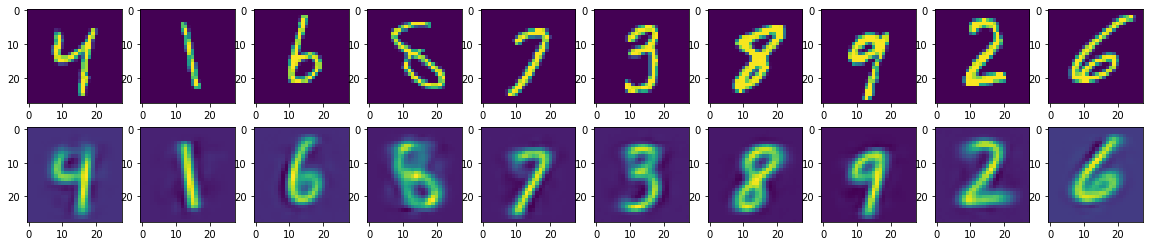

Denoise Auto Encoder


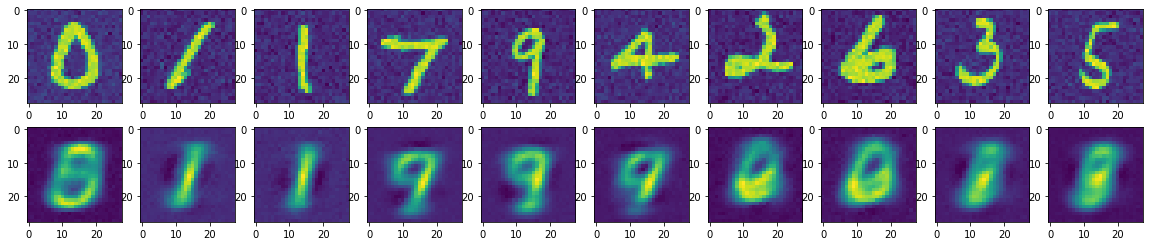

In [13]:
print('Simple Auto Encoder')
draw_new_images(AE)
print('Denoise Auto Encoder')
draw_new_images(DAE, True)

# Training with New Images

In [14]:
def draw_wrong_images(X_test, y_test, y_pred, denoise = False) : 
    import matplotlib
    import matplotlib.pyplot as plt
    plt.figure(figsize = (6,12))
    wrong_idxes = [idx for idx,x in enumerate(y_test == pred) if x == False]
    wrong_images = X_test[wrong_idxes].reshape(-1,28,28)
    wrong_labels = y_pred[wrong_idxes]
    correct_labels = y_test[wrong_idxes]

    for i in  range(1,11) : 
        rs = np.random.randint(len(wrong_idxes))
        wrong_image = wrong_images[rs]
        wrong_label = wrong_labels[rs]
        correct_label = correct_labels[rs] 
        plt.subplot(5,2,i)
        plt.imshow(wrong_image)
        plt.title(f'{correct_label} => {wrong_label}')
        plt.axis('off')

In [15]:
AE_train_images = AE.predict(X_train_images)
AE_valid_images = AE.predict(X_valid_images)

DAE_train_images = DAE.predict(X_train_images)
DAE_valid_images = DAE.predict(X_valid_images)

===  AE STRATED ===


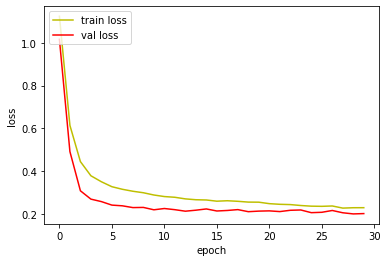

Train Accuracy :  0.940541684627533
Valid Accuracy :  0.9449999928474426
Test  Accuracy :  0.8459
===  DAE STRATED ===


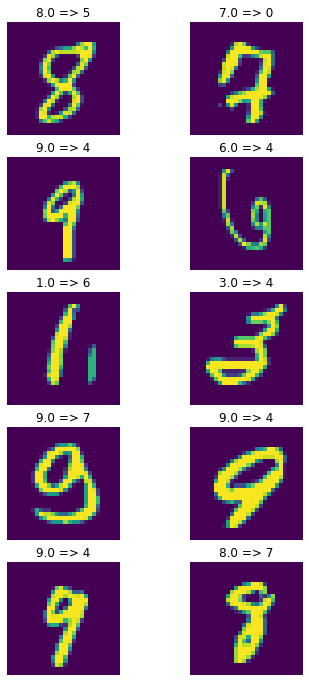

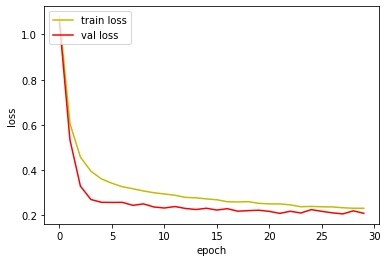

Train Accuracy :  0.9392499923706055
Valid Accuracy :  0.9439166784286499
Test  Accuracy :  0.8538


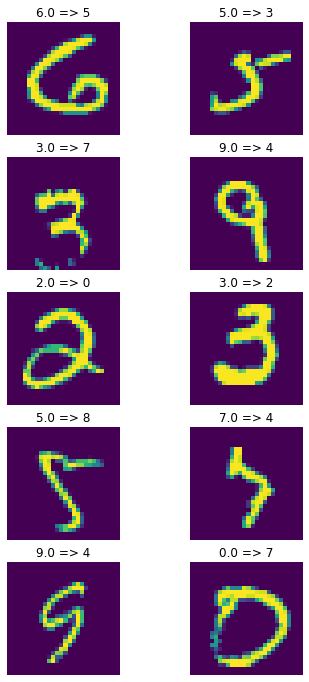

In [16]:
for encoder, encoder_name in zip([AE,DAE], ['AE','DAE']) : 
        print('=== ',encoder_name, 'STRATED ===')


        mlp = MLP_Classifier()
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
        mlp.compile(optimizer, loss = loss_fn, metrics = ['accuracy'])

        mlp_ckpt = 'checkpoint.h5'
        patience = 20
        history = mlp.fit(AE_train_images, X_train_labels,
                validation_data = (AE_valid_images, X_valid_labels),
                batch_size = 480,
                epochs = 30,
                verbose = 0, 
                callbacks= return_callbacks(mlp_ckpt, patience)
                )
        mlp.load_weights(mlp_ckpt)
        draw_history(history)

        y_pred = mlp.predict(X_test)
        pred = np.argmax(y_pred, axis = 1)
        accuracy = sum(pred == y_test) / y_test.shape[0]

        best_epoch = np.argmin(history.history['val_loss'])

        print('Train Accuracy : ', history.history['accuracy'][best_epoch])
        print('Valid Accuracy : ', history.history['val_accuracy'][best_epoch])
        print('Test  Accuracy : ', accuracy)

        draw_wrong_images(X_test, y_test, pred)

